# Nordic Optical Telescope images of Ou 5

Images from ALFOSC instrument downloaded from IAC with help of Sergio Armas Pérez <sap@not.iac.es> 2025-07-05

## Imports

In [594]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from mes_longslit import regrid_images

## Load headers from all the individual images

In [595]:
datadir = Path.cwd().parent / "data/nordic-images"
_files = sorted(datadir.glob("AL*.fits"))
primary_headers = {
    _.stem: fits.open(_)[0].header
    for _ in _files
}
# list(primary_headers.keys())

## Make table of relevant data from the headers

We want the filters and the exposure time at least

In [596]:
tab = Table(
    [
        {"Name": _name, 
         **{_key: primary_headers[_name][_key] 
            for _key in ["ALFLTNM", "FBFLTNM", "EXPTIME", "DATE-OBS"]}
        }
        for _name in primary_headers
    ]
)
tab

Name,ALFLTNM,FBFLTNM,EXPTIME,DATE-OBS
str10,str13,str12,float64,str23
ALwj290115,i_int 797_157,Open,120.0,2013-10-29T19:27:35.209
ALwj290116,Open,Open,60.0,2013-10-29T19:30:31.195
ALwj290117,i_int 797_157,Open,60.0,2013-10-29T19:33:02.715
ALwj290240,i_int 797_157,Open,120.0,2013-10-30T02:31:07.698
ALwj290241,i_int 797_157,Open,60.0,2013-10-30T02:33:49.828
ALwk070080,Open,[OIII] 501_3,900.0,2013-11-07T21:41:34.675
ALwk070081,Open,[OIII] 501_3,900.0,2013-11-07T21:57:09.752
ALwk070097,Open,Halp 658_18,900.0,2013-11-07T23:21:52.391
ALwk070098,Open,Halp 658_18,900.0,2013-11-07T23:37:27.275


So the continuum images have the ALFLTNM and the line images have the FBFLTNM

## Select the frames for each emission line

In [597]:
emline_frame_names = {
    "ha": ["ALwk070097", "ALwk070098"],
    "oiii": ["ALwk070080", "ALwk070081"],
    "heii": ["ALze250092", "ALze250093", "ALze250094"], 
}

In [598]:
hdus = {
    _line: [
        fits.open(datadir / (_name + ".fits"))[1]
        for _name in _names
    ] for _line, _names in emline_frame_names.items()
}

In [599]:
hdus

{'ha': [<astropy.io.fits.hdu.image.ImageHDU at 0x4a3167510>,
 'oiii': [<astropy.io.fits.hdu.image.ImageHDU at 0x4a313f810>,
 'heii': [<astropy.io.fits.hdu.image.ImageHDU at 0x4a317a210>,
  <astropy.io.fits.hdu.image.ImageHDU at 0x4a31329d0>]}

## Reproject all frames to a common grid

### Look at an example full frame

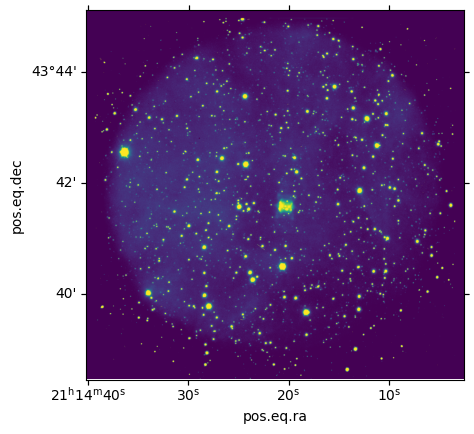

In [600]:
hdu = hdus["ha"][0]
w = WCS(hdu.header)
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(hdu.data, origin="lower", vmin=11000, vmax=13000)

Here we see the PN surrounded by diffuse emission from the foreground H II region Sh 2-119

In [601]:
bias = np.median(hdu.data[:100, :100])
bias

10016.0

### Reference coordinate for the PN from Simbad. 

Hopefully, this is the position of the central star

In [602]:
c0 = SkyCoord.from_name("PN Ou 5")
c0.ra.to_string(u.hour), c0.dec.to_string(u.deg)

('21h14m20.03539402s', '43d41m36.04832234s')

### Zoom in on the PN

In [603]:
w.world_to_pixel(c0)

(array(1147.30186152), array(991.37403499))

Pixel size

In [604]:
3600 * w.wcs.cd[1, 1]

0.1903094997031854

So that is about 0.2 arcsec. Make a window of 80 arcsec square, as I did previously in 01-01-median-image notebook

In [605]:
j0, i0 = w.world_to_array_index(c0)

In [606]:
zoom_size = 40
zoom_xslice = slice(i0 - 5 * zoom_size, i0 + 5 * zoom_size)
zoom_yslice = slice(j0 - 5 * zoom_size, j0 + 5 * zoom_size)
zoom_xslice, zoom_yslice

(slice(947, 1347, None), slice(791, 1191, None))

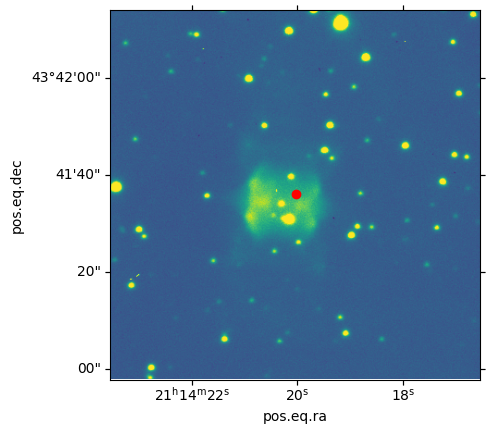

In [607]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(hdu.data - bias, origin="lower", vmin=0, vmax=4000)
ax.set_xlim(zoom_xslice.start, zoom_xslice.stop)
ax.set_ylim(zoom_yslice.start, zoom_yslice.stop)
ax.plot_coord(c0, "o", color="r")

CSPN is not centered. I have measured its pixel position in DS9

In [608]:
istar, jstar = 1133.454, 981.86892
istar - i0, jstar - j0

(-13.54600000000005, -9.131079999999997)

### Fix the alignment

So one way of fixing it is to set crpix to [istar, jstar] and crval to c0

In [609]:
wfix = w.copy()
wfix.wcs.crpix = istar, jstar
wfix.wcs.crval = c0.ra.deg, c0.dec.deg

Recalculate the zoom window around the corrected position

In [610]:
j0, i0 = wfix.world_to_array_index(c0)
zoom_size = 35
zoom_xslice = slice(i0 - 5 * zoom_size, i0 + 5 * zoom_size)
zoom_yslice = slice(j0 - 5 * zoom_size, j0 + 5 * zoom_size)
zoom_xslice, zoom_yslice

(slice(957, 1307, None), slice(806, 1156, None))

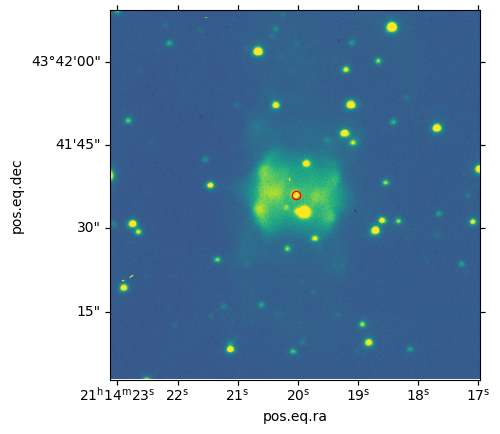

In [611]:
fig, ax = plt.subplots(subplot_kw=dict(projection=wfix))
ax.imshow(hdu.data - bias, origin="lower", vmin=0, vmax=4000)
ax.set_xlim(zoom_xslice.start, zoom_xslice.stop)
ax.set_ylim(zoom_yslice.start, zoom_yslice.stop)
ax.plot_coord(c0, "o", color="r", fillstyle="none")

### Do the reprojection of all the images

We will use my `mes_longslit.regrid_images()` function, but first we need to measure the pixel position of the central star on all the images. 

I do this by hand in DS9 and record the results in the following dict:

In [612]:
crpix_CSPN = {
    "ALwk070097": (1133.454, 981.86892), 
    "ALwk070098": (1054.2045, 982.06465),
    "ALwk070080": (1096.16, 980.96),
    "ALwk070081": (1017.3492, 981.18918),
    "ALze250092": (1062.6922, 1017.6262),
    "ALze250093": (1061.9223, 1017.9001),
    "ALze250094": (1061.5267, 1018.005),
}

Fixup all the alignments, writing back into the HDU headers. And subtract bias while we are at it.

Also subtract the hii region backgound. We can use a percentile of the full image to get a suitable BG level, but this may need to be tuned by line

*Update 2025-07-12* We adjust the plate scale of the heii images by 2%, so that the stars line up better.

In [613]:
bgcentiles = {
    "ha": 75,
    "oiii": 75,
    "heii": 85,
}

for _line in "ha", "oiii", "heii":
    for _hdu, _name in zip(hdus[_line], emline_frame_names[_line]):
        w = WCS(_hdu.header)
        w.wcs.crpix = crpix_CSPN[_name]
        w.wcs.crval = c0.ra.deg, c0.dec.deg
        if _line == "heii":
            w.wcs.cd *= 1.02
        _hdu.header.update(w.to_header())
        _hdu.data = _hdu.data.astype("float")
        bg = np.percentile(_hdu.data, bgcentiles[_line])
        _hdu.data -= bg
        print(_line, bg)

ha 11208.0
ha 11216.0
oiii 10121.0
oiii 10134.0
heii 13334.0
heii 13225.0
heii 13091.0


This works mostly fine, but it does mean that the bg-subtracted image in Ha goes negative to the E of the PN, since the H II region brightness has a minimum there

In [614]:
fits.HDUList([hdu])

In [615]:
new_hdus = {
    _line: [
        regrid_images(
            fits.HDUList([_hdu]),
            center=c0, 
            pixscale=0.2 * u.arcsec,
            shape=(400, 400),
        )[0]
        for _hdu in hdus[_line]
    ]
    for _line in ["ha", "oiii", "heii"]
}

In [616]:
new_hdus

{'ha': [<astropy.io.fits.hdu.image.ImageHDU at 0x4a26bc850>,
 'oiii': [<astropy.io.fits.hdu.image.ImageHDU at 0x484e084d0>,
 'heii': [<astropy.io.fits.hdu.image.ImageHDU at 0x4a318a590>,
  <astropy.io.fits.hdu.image.ImageHDU at 0x4c05f4e90>]}

### Check that they came out ok

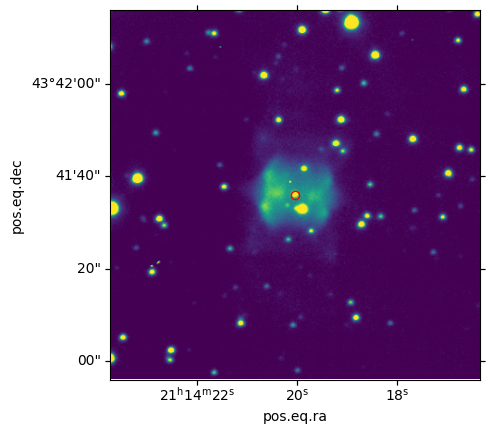

In [617]:
hdu = new_hdus["ha"][0]
w = WCS(hdu.header)
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(hdu.data, origin="lower", vmin=0, vmax=3000)
ax.plot_coord(c0, "o", color="r", fillstyle="none")

### Save the regridded aligned images

In [618]:
for _line in "ha", "oiii", "heii":
    for _i, _hdu in enumerate(new_hdus[_line]):
        _hdu.writeto(
            datadir / f"nordic-ou5-{_line}-{_i:02d}-regrid.fits",
            overwrite=True,
        )

## Co-add all exposures of each line

This is most useful for He II, which has three images. We can take the median and use outliers to make a mask for eliminating CR by setting to NaN, then use nanmean to combine the 3 images and get best SNR. 

### Co-add He II frames

In [619]:
heii_stack = np.stack(
    [_hdu.data for _hdu in new_hdus["heii"]]
)
heii_stack.shape

(3, 400, 400)

In [620]:
heii_median = np.median(heii_stack, axis=0, keepdims=True)
heii_std = np.std(heii_stack, axis=0, keepdims=True)
heii_std_med = np.median(heii_std)
heii_std_med, np.min(heii_std), np.max(heii_std)

(63.07869523640739, 0.04876967583656262, 36766.015047927925)

So we do some sort of fake sigma clipping across the three frames for each pixel

Question is whether to use a single sigma for all, or to adapt it. Here is image of the sigma

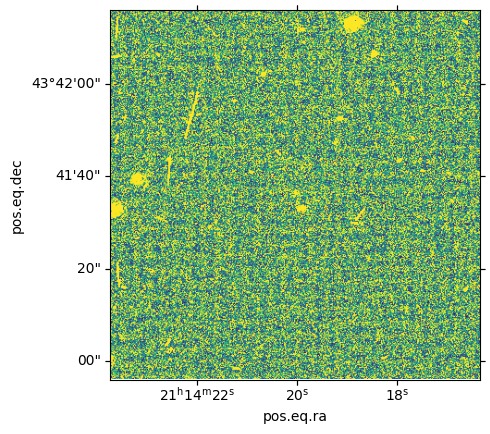

In [621]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(heii_std[0], origin="lower", vmin=0, vmax=100)

I have experimented with various values and 1.5 sigma seems the best threshold. More than 2.0 gets zero pixels, and much less gives too many hits. I also put a condition on the brightness, so we do not get too many false positives

In [622]:
badmask = (
    (np.abs(heii_stack - heii_median) > 1.5 * heii_std) 
    & (heii_stack > 800)
)
np.sum(badmask)

1886

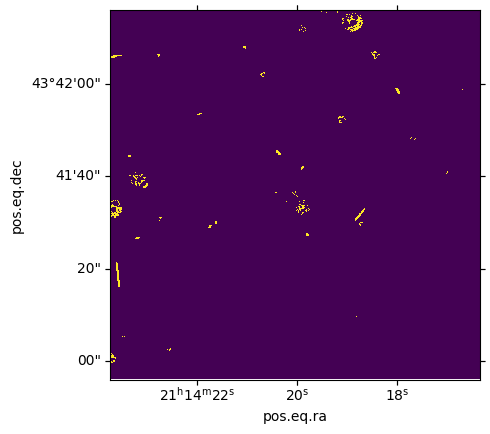

In [623]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(badmask[1], origin="lower", vmin=0, vmax=1, interpolation="none")

In [624]:
heii_stack[badmask] = np.nan

In [625]:
heii_mean = np.nanmean(heii_stack, axis=0)

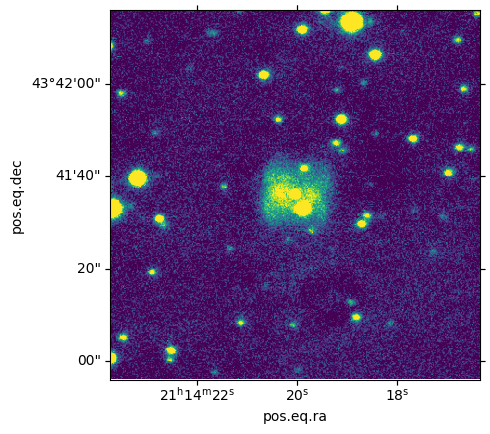

In [626]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(heii_mean, origin="lower", vmin=0, vmax=600, interpolation="none")

In [627]:
heii_hdu = fits.PrimaryHDU(
    header=new_hdus["heii"][0].header,
    data=heii_mean,
)
heii_hdu.writeto(
    datadir / f"nordic-ou5-heii-coadd-regrid.fits",
    overwrite=True,    
)

### Co-add H alpha frames

We only have two frames, but it is still worthwhile combining them

In [628]:
ha_stack = np.stack(
    [_hdu.data for _hdu in new_hdus["ha"]]
)
ha_stack.shape

(2, 400, 400)

In [629]:
from scipy import ndimage

In [630]:
ha_median = np.median(ha_stack, axis=0, keepdims=True)
ha_std = np.std(ha_stack, axis=0, keepdims=True)
ha_std_med = np.median(ha_std)
ha_std_med, np.min(ha_std), np.max(ha_std)

(20.990351186952097, 2.9174816978283502e-05, 16934.141517664626)

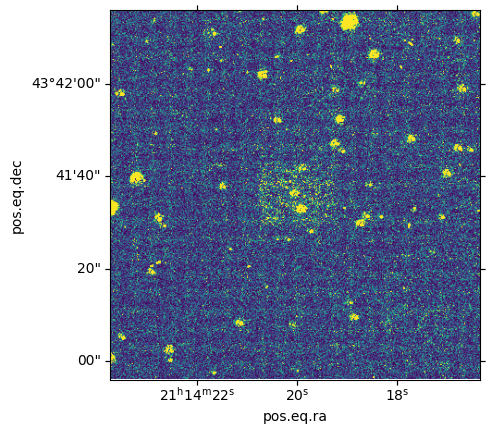

In [631]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(ha_std[0], origin="lower", vmin=0, vmax=100)

Here we have to work harder to get a good mask. As well as the conditions on the brightness and the deviation from the median, we also require the pixel to be at least 3 times brighter than its pair in the other frame.

In [632]:
badmask = (
    (np.abs(ha_stack - ha_median) > 100) 
    & (ha_stack > 100)
    & (ha_stack > 1.2 * np.min(ha_stack, axis=0, keepdims=True))
)
np.sum(badmask)

1121

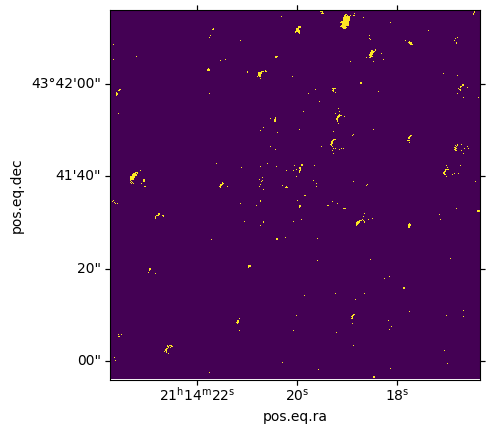

In [633]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(badmask[1], origin="lower", vmin=0, vmax=1, interpolation="none")

In [634]:
ha_stack[badmask] = np.nan

In [635]:
ha_mean = np.nanmean(ha_stack, axis=0)

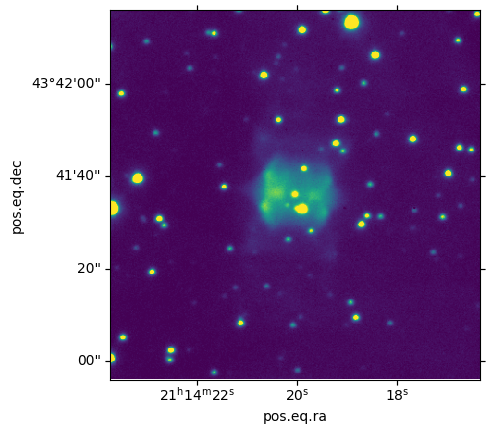

In [636]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(ha_mean, origin="lower", vmin=-100, vmax=3000, interpolation="none")

In [637]:
ha_hdu = fits.PrimaryHDU(
    header=new_hdus["ha"][0].header,
    data=ha_mean,
)
ha_hdu.writeto(
    datadir / f"nordic-ou5-ha-coadd-regrid.fits",
    overwrite=True,    
)

### Oiii frames (nothing to do)

The second Oiii frame is much weaker - maybe affected by cloud. So there is no advantage in combining the two frames.


In [638]:
oiii_hdu = fits.PrimaryHDU(
    header=new_hdus["oiii"][0].header,
    data=new_hdus["oiii"][0].data,
)
oiii_hdu.writeto(
    datadir / f"nordic-ou5-oiii-coadd-regrid.fits",
    overwrite=True,    
)

## Color images


In [639]:
def rescale(im, vmin, vmax):
    """
    Rescale image to range 0.0->1.0
    """
    return np.where(
        im > vmin,
        np.where(
            im < vmax,
            (im - vmin) / (vmax - vmin),
            1.0,
        ),
        0.0,
    )

In [640]:
rgbim = np.stack(
    [
        rescale(heii_hdu.data, 0, 600),
        rescale(ha_hdu.data, -200, 3000) ** 0.5,
        rescale(oiii_hdu.data, -90, 1500) ** 0.4,
    ],
    axis=-1,
)

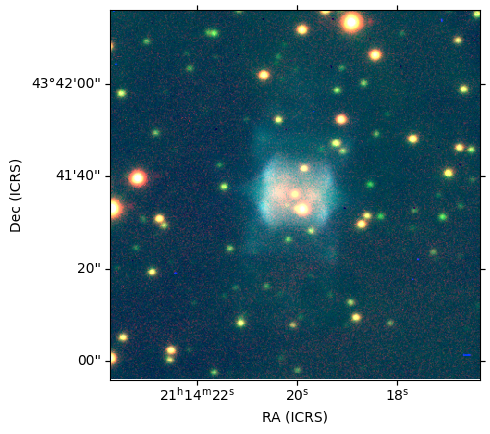

In [643]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(rgbim, origin="lower", interpolation="none")
ax.set_xlabel("RA (ICRS)")
ax.set_ylabel("Dec (ICRS)")

In [645]:
figfile = "nordic-pn-ou5-rgb-image.pdf"
fig.savefig(figfile, bbox_inches="tight")
fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

## Remove the stars

Find the stars and remove them from the image

## Reproject onto nebular axis-equator frame



In [651]:
nebframe = c0.skyoffset_frame(rotation=10 * u.deg)

In [652]:
nebframe

<SkyOffsetICRS Frame (rotation=10.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (318.58348081, 43.69334676)>)>

Actually this is very simple. I do not need to use a skyoffset frame. I just need to rotate the CD matrix, but I need to work out whether the rotation should be positive or negative

In [653]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 318.5834808084 43.693346756204 
CRPIX : 200.5 200.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -5.5555555555556e-05 5.5555555555556e-05 
NAXIS : 400  400

Set the rotation angle

In [686]:
theta = 6 * u.deg
cth, sth = np.cos(theta), np.sin(theta)

Make a rotated WCS centered on the CSPN

In [687]:
wrot = WCS(naxis=2)

In [688]:
wrot.wcs.crpix = w.wcs.crpix
wrot.wcs.cdelt = w.wcs.cdelt
wrot.wcs.crval = w.wcs.crval
wrot.wcs.ctype = w.wcs.ctype
wrot.wcs.pc = [[cth, sth], [-sth, cth]]
wrot

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 318.5834808084 43.693346756204 
CRPIX : 200.5 200.5 
PC1_1 PC1_2  : 0.9945218953682733 0.10452846326765347 
PC2_1 PC2_2  : -0.10452846326765347 0.9945218953682733 
CDELT : -5.5555555555556e-05 5.5555555555556e-05 
NAXIS : 0  0

Do the projections

In [689]:
from reproject import reproject_exact

In [692]:
ha_imrot = reproject_exact(
    ha_hdu, wrot, ha_hdu.data.shape, return_footprint=False,
)
heii_imrot = reproject_exact(
    heii_hdu, wrot, heii_hdu.data.shape, return_footprint=False,
)
oiii_imrot = reproject_exact(
    oiii_hdu, wrot, oiii_hdu.data.shape, return_footprint=False,
)

Check the result

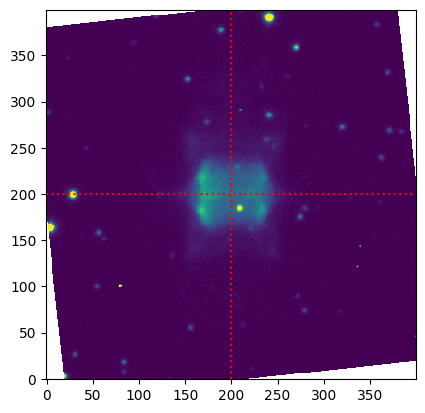

In [694]:
fig, ax = plt.subplots()
ax.imshow(oiii_imrot, origin="lower", interpolation="none", vmin=0, vmax=1500)
ax.axhline(w.wcs.crpix[1] - 1, color="r", ls="dotted")
ax.axvline(w.wcs.crpix[1] - 1, color="r", ls="dotted")


This looks good for a rotation of 6 degrees

## Profiles along axis and equator

Set up offset coordinate arrays in arcsec

In [702]:
ny, nx = ha_imrot.shape
j0, i0 = wrot.wcs.crpix
j0 -= 1
i0 -= 1
pixel = 0.2
x = (np.arange(nx) - i0) * pixel
y = (np.arange(ny) - j0) * pixel
X, Y = np.meshgrid(x, y)

Slice windows for simulating slits. I have experimented with different values for `half_width` and it seems that 2 arcsec is the best for the median profiles, especially the equatorial cut, which is the most important

In [843]:
half_width = 2.0
slit_slice = slice(
    int(i0 - half_width / pixel), 
    int(i0 + half_width / pixel) + 1,
)
slit_slice

slice(189, 210, None)

In [844]:
_norm = {"ha": 2500, "oiii": 1000, "heii": 700}
# Use the same order as RGB image to get consistent colors
_imrot = {
    "heii": heii_imrot,
    "ha": ha_imrot, 
    "oiii": oiii_imrot, 
}
_label = {
    "heii": r"He II $\lambda 4686$",
    "ha": r"H$\alpha$ $\lambda 6563$", 
    "oiii": r"[O III] $\lambda 5007$", 
}
_mean = {
    _id: np.mean(_imrot[_id][slit_slice, :], axis=0) / _norm[_id]
    for _id in _imrot
} 
_median = {
    _id: np.median(_imrot[_id][slit_slice, :], axis=0) / _norm[_id]
    for _id in _imrot
} 
_std = {
    _id: np.std(_imrot[_id][slit_slice, :], axis=0) / _norm[_id]
    for _id in _imrot
} 
_q1 = {
    _id: np.percentile(_imrot[_id][slit_slice, :], 25, axis=0) / _norm[_id]
    for _id in _imrot
} 
_p10 = {
    _id: np.percentile(_imrot[_id][slit_slice, :], 10, axis=0) / _norm[_id]
    for _id in _imrot
} 
_q3 = {
    _id: np.percentile(_imrot[_id][slit_slice, :], 75, axis=0) / _norm[_id]
    for _id in _imrot
} 

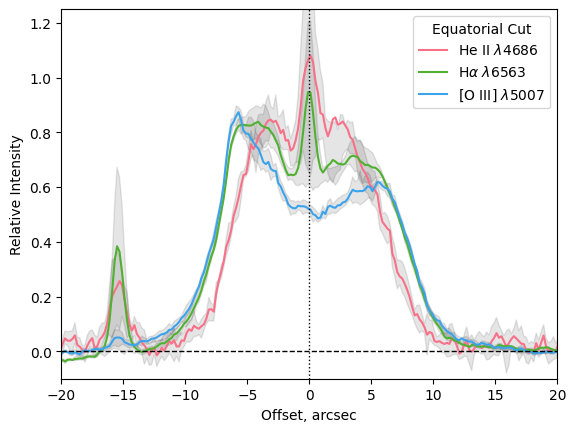

In [845]:
with sns.color_palette("husl", n_colors=3):
    fig, ax = plt.subplots()
    for _id in _imrot:
        line, = ax.plot(x, _mean[_id], label=_label[_id])
        ax.fill_between(
            # x, _mean[_id] - _std[_id], _mean[_id] + _std[_id], 
            x, _q1[_id], _q3[_id],
            alpha=0.1,
            # color=line.get_color(),
            color="k",
        )
    ax.axhline(0.0, color="k", linestyle="dashed", lw=1)
    ax.axvline(0.0, color="k", linestyle="dotted", lw=1)
    
    ax.set_xlim(-20, 20)
    ax.set_ylim(-0.1, 1.25)
    ax.set_xlabel("Offset, arcsec")
    ax.set_ylabel("Relative Intensity")
    ax.legend(title="Equatorial Cut")

In [846]:
figfile = "nordic-pn-ou5-equator-profile.pdf"
fig.savefig(figfile, bbox_inches="tight")
fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

Repeat for polar profile

In [847]:
_mean_p = {
    _id: np.mean(_imrot[_id][:, slit_slice], axis=1) / _norm[_id]
    for _id in _imrot
} 
_median_p = {
    _id: np.median(_imrot[_id][:, slit_slice], axis=1) / _norm[_id]
    for _id in _imrot
} 
_q1_p = {
    _id: np.percentile(_imrot[_id][:, slit_slice], 25, axis=1) / _norm[_id]
    for _id in _imrot
} 
_p10_p = {
    _id: np.percentile(_imrot[_id][:, slit_slice], 10, axis=1) / _norm[_id]
    for _id in _imrot
} 
_q3_p = {
    _id: np.percentile(_imrot[_id][:, slit_slice], 75, axis=1) / _norm[_id]
    for _id in _imrot
}

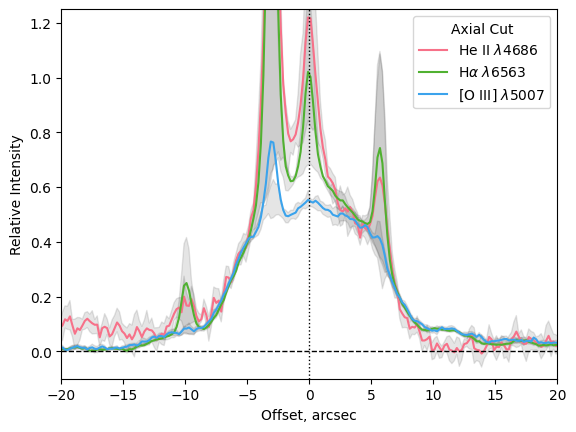

In [848]:
with sns.color_palette("husl", n_colors=3):
    fig, ax = plt.subplots()
    for _id in _imrot:
        line, = ax.plot(x, _mean_p[_id], label=_label[_id])
        ax.fill_between(
            x, _q1_p[_id], _q3_p[_id],
            alpha=0.1,
            color="k",
        )
    ax.axhline(0.0, color="k", linestyle="dashed", lw=1)
    ax.axvline(0.0, color="k", linestyle="dotted", lw=1)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-0.1, 1.25)
    ax.set_xlabel("Offset, arcsec")
    ax.set_ylabel("Relative Intensity")
    ax.legend(title="Axial Cut")

Try a version using percentiles to avoid the stars

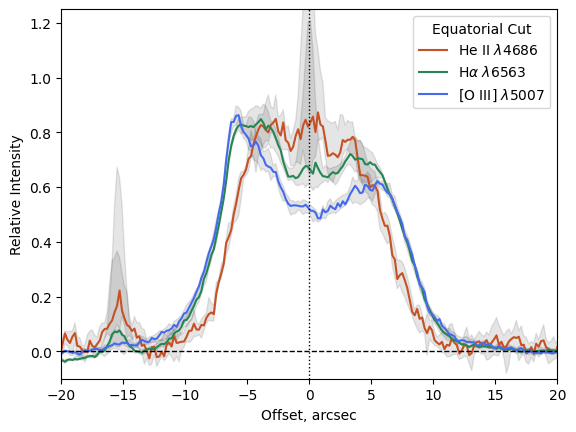

In [849]:
with sns.husl_palette(l=0.5, h=0.06, n_colors=3):
    fig, ax = plt.subplots()
    for _id in _imrot:
        line, = ax.plot(x, _median[_id], label=_label[_id])
        ax.fill_between(
            # x, _mean[_id] - _std[_id], _mean[_id] + _std[_id], 
            x, _q1[_id], _q3[_id],
            alpha=0.1,
            # color=line.get_color(),
            color="k",
        )
    ax.axhline(0.0, color="k", linestyle="dashed", lw=1)
    ax.axvline(0.0, color="k", linestyle="dotted", lw=1)
    
    ax.set_xlim(-20, 20)
    ax.set_ylim(-0.1, 1.25)
    ax.set_xlabel("Offset, arcsec")
    ax.set_ylabel("Relative Intensity")
    ax.legend(title="Equatorial Cut")

In [850]:
figfile = "nordic-pn-ou5-equator-profile-median.pdf"
fig.savefig(figfile, bbox_inches="tight")
fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

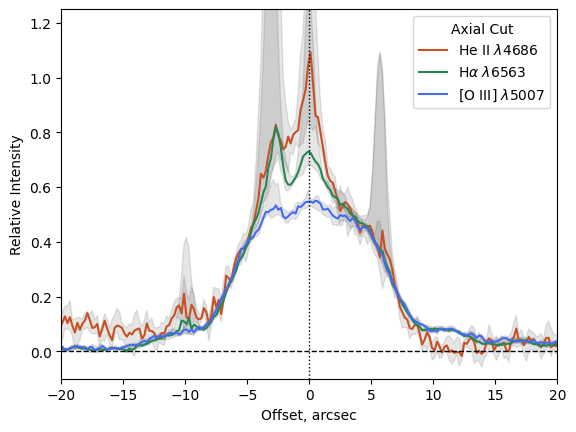

In [851]:
with sns.husl_palette(l=0.5, h=0.06, n_colors=3):
    fig, ax = plt.subplots()
    for _id in _imrot:
        line, = ax.plot(x, _median_p[_id], label=_label[_id])
        ax.fill_between(
            x, _q1_p[_id], _q3_p[_id],
            alpha=0.1,
            color="k",
        )
    ax.axhline(0.0, color="k", linestyle="dashed", lw=1)
    ax.axvline(0.0, color="k", linestyle="dotted", lw=1)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-0.1, 1.25)
    ax.set_xlabel("Offset, arcsec")
    ax.set_ylabel("Relative Intensity")
    ax.legend(title="Axial Cut")

In [852]:
figfile = "nordic-pn-ou5-polar-profile-median.pdf"
fig.savefig(figfile, bbox_inches="tight")
fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")